In [1]:
import math
import sys

import numpy as np
from scipy.ndimage import gaussian_filter
from scipy.stats import multivariate_normal


import torch
import torch.nn as nn

import matplotlib.pyplot as plt

sys.path.append('..')

from src.features.dihedral import DihedralLayer

from dihedral import cal_dihedral

coords_path = "../../data/NPY/c_trj.npy"
forces_path = "../../data/NPY/f_trj.npy"

In [2]:
coords = np.load(coords_path)
forces = np.load(forces_path)

In [3]:
dihedral, rad = DihedralLayer(coords.shape[1])(torch.tensor(coords))
dihedral = dihedral.numpy()

In [4]:
psi, phi = rad
psi = psi.numpy()
phi = phi.numpy()
psi = np.rad2deg(psi)
phi = np.rad2deg(phi)
psi = psi.reshape(-1)
phi = phi.reshape(-1)

In [5]:
print(psi.shape)
print(phi.shape)

(17990982,)
(17990982,)


In [6]:
# plt.scatter(phi, psi)
# plt.show()

In [53]:
grid = 200
delta = 360 / grid

cmap = np.zeros((grid, grid))
psi_deg = psi + 179
phi_deg = phi + 179

for i in range(psi_deg.shape[0]):
    phi_grid = int(phi_deg[i] / delta)
    psi_grid = int(psi_deg[i] / delta)
    cmap[psi_grid, phi_grid] += 1

In [54]:
def plot_cmap_heat(grid, cmap):
    fig, ax = plt.subplots()
    # heatmap = ax.pcolor(cmap, cmap=plt.cm.Blues)
    cmap_ = np.copy(cmap)
    cmap_[cmap_ > 1] = np.log(cmap_[cmap_ > 1])
#     heatmap = ax.pcolor(cmap, cmap=plt.cm.Blues)
    heatmap = ax.pcolor(cmap_)
    plt.show()

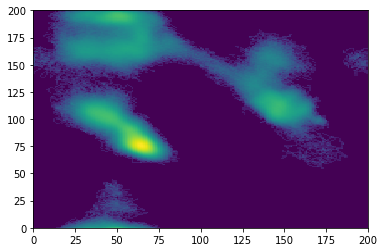

In [55]:
plot_cmap_heat(grid, cmap)

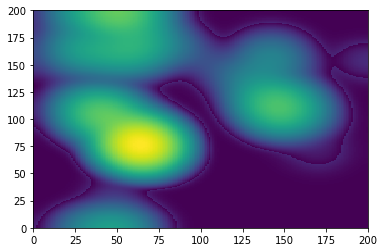

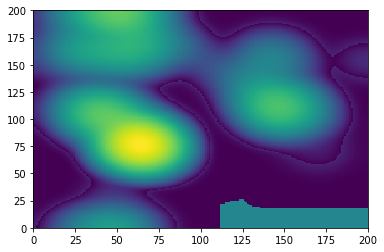

In [58]:
filterd_cmap = gaussian_filter(cmap, sigma=8, truncate=4)
# filterd_cmap = gaussian_filter(filterd_cmap, sigma=1, truncate=10)
plot_cmap_heat(grid, filterd_cmap)

filterd_cmap_ = np.copy(filterd_cmap)
filterd_cmap_[filterd_cmap_ == 0] = 100
plot_cmap_heat(grid, filterd_cmap_)

In [49]:
m = 2 #dimension
mean = np.zeros(m)
sigma = np.eye(m)

N = grid


def plot_energy_surface(cmap_, epsilon):
    cmap_ = cmap_ + epsilon
    energy = -1 * np.log(cmap_)
    energy = energy + np.abs(np.min(energy))
    
    x1 = np.linspace(0, 50, N)
    x2 = np.linspace(0, 50, N)

    X1, X2 = np.meshgrid(x1, x2)
    X = np.c_[np.ravel(X1), np.ravel(X2)]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=50, azim=45)
    surf = ax.plot_surface(X1, X2, energy, cmap='bwr', linewidth=0)
    fig.colorbar(surf)
#     ax.set_title("Surface Plot")
    fig.show()
    plot_cmap_heat(grid, energy)

<ipython-input-49-c2fafffa258f>:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


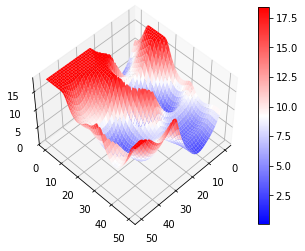

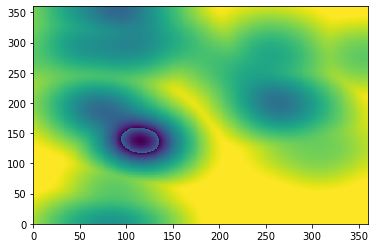

In [50]:
plot_energy_surface(filterd_cmap, 1e-4)

<ipython-input-49-c2fafffa258f>:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


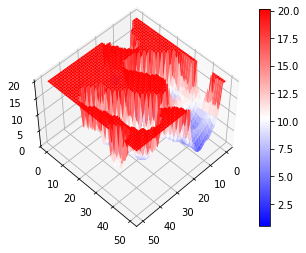

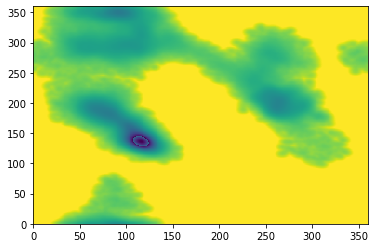

In [51]:
plot_energy_surface(cmap, 1e-4)

In [39]:
# Forceの可視化

def cal_energy(cmap_, epsilon=1e-4):
    cmap_ = cmap_ + epsilon
    energy = -1 * np.log(cmap_)
    energy = energy + np.abs(np.min(energy)) + epsilon
    return energy

def cal_force(energy):
    force_x = np.zeros_like(energy)
    force_y = np.zeros_like(energy)
    
    for i in range(grid):
        for j in range(grid):
            x_max = 0 if i == grid - 1 else i + 1
            x_min = i - 1
            
            y_max = 0 if j == grid - 1 else j + 1
            y_min = j - 1
            
#             print(x_max, x_min, y_max, y_min)
            
            force_x[i,j] = -1 * (energy[x_max, j] - energy[x_min, j]) / delta
            force_y[i,j] = -1 * (energy[i, y_max] - energy[i, y_min]) / delta
            
    return force_x, force_y

In [40]:
def cmap_forces(energy, log=False, stride=1):
    cmap_force_x, cmap_force_y = cal_force(energy)
    
    N = cmap_force_x.shape[0] // stride

    cmap_force_x = cmap_force_x[::stride, ::stride]
    cmap_force_y = cmap_force_y[::stride, ::stride]
    
    x1 = np.linspace(0, N, N)
    x2 = np.linspace(0, N, N)
    x1 = np.linspace(0, N, N)
    x2 = np.linspace(0, N, N)
    
    xx, yy = np.meshgrid(x1, x2)
    if log:
        cmap_force_x_sign = np.sign(cmap_force_x)
        cmap_force_y_sign = np.sign(cmap_force_y)
        cmap_force_x = np.log(np.abs(cmap_force_x)) * cmap_force_x_sign
        cmap_force_y = np.log(np.abs(cmap_force_y)) * cmap_force_y_sign
    plt.quiver(xx, yy, cmap_force_y, cmap_force_x)
    plt.figure(dpi=1, figsize=(10, 10))
    plt.show()

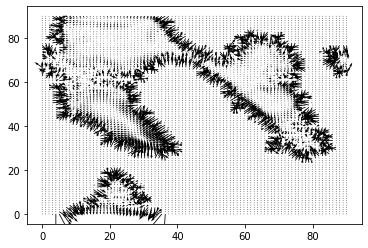

<Figure size 10x10 with 0 Axes>

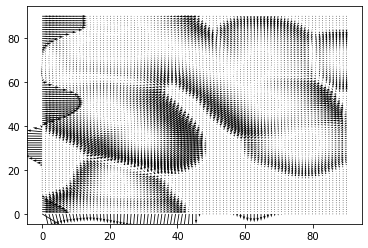

<Figure size 10x10 with 0 Axes>

In [41]:
# cmap_force_x, cmap_force_y = cal_force(cmap)

# x1 = np.linspace(0, 50, N)
# x2 = np.linspace(0, 50, N)

# xx, yy = np.meshgrid(x1, x2)

# plt.quiver(xx, yy, cmap_force_x, cmap_force_y)
# plt.show()
cmap_energy = cal_energy(cmap)
filterd_energy = cal_energy(filterd_cmap)

cmap_forces(cmap_energy,stride=4)
cmap_forces(filterd_energy, stride=4)

In [18]:
flatten_cmap = cmap.reshape(-1)
psi_idx = 5
phi_idx = 15

cmap_10_15 = cmap[psi_idx, phi_idx]
flatten_10_15 = flatten_cmap[psi_idx * grid + phi_idx]
print(cmap_10_15, flatten_10_15)

0.0 0.0


In [19]:
from src.layers.cmap import prepare_cmap_force_grad

In [30]:
cmap, energy, force = prepare_cmap_force_grad(coords, grid_size=grid, sigma=10)

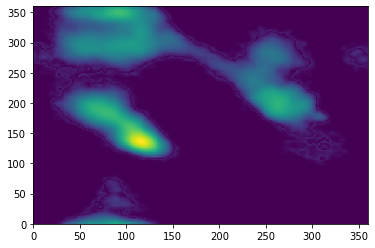

In [31]:
plot_cmap_heat(100, cmap.copy())

<ipython-input-11-c2fafffa258f>:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


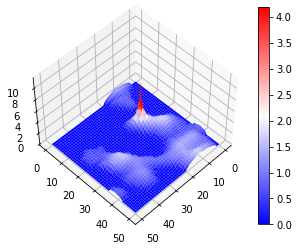

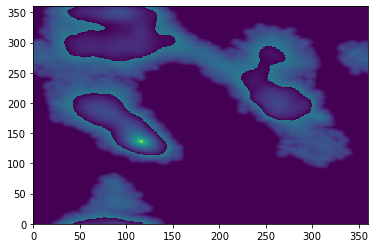

In [32]:
plot_energy_surface(energy.copy(), 1e-4)

In [33]:
def cmap_forces(cmap_force_x, cmap_force_y, log=False, stride=1):
#     cmap_force_x, cmap_force_y = cal_force(energy)
    N = cmap_force_x.shape[0] // stride

    cmap_force_x = cmap_force_x[::stride, ::stride]
    cmap_force_y = cmap_force_y[::stride, ::stride]
    
    x1 = np.linspace(0, N, N)
    x2 = np.linspace(0, N, N)
    
    xx, yy = np.meshgrid(x1, x2)
    if log:
        cmap_force_x_sign = np.sign(cmap_force_x)
        cmap_force_y_sign = np.sign(cmap_force_y)
        cmap_force_x = np.log(np.abs(cmap_force_x)) * cmap_force_x_sign
        cmap_force_y = np.log(np.abs(cmap_force_y)) * cmap_force_y_sign
    plt.quiver(xx, yy, cmap_force_y, cmap_force_x)
    plt.figure(dpi=1, figsize=(10, 10))
    plt.show()

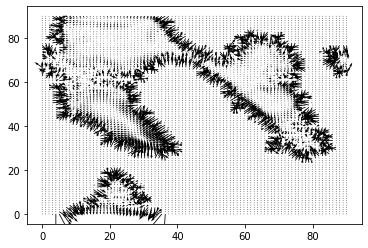

<Figure size 10x10 with 0 Axes>

In [34]:
cmap_forces(force[0], force[1], stride=4)